In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/jubins/IDS-Project-Bank-Marketing-Analysis/master/bank-additional-full.csv'
df = pd.read_csv(data, sep=';')
bank_df = df.copy()
print(df.shape)
df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Exploratory Analysis of feature importance among target and variables

#### Identifying Imbalance and Missingness in data

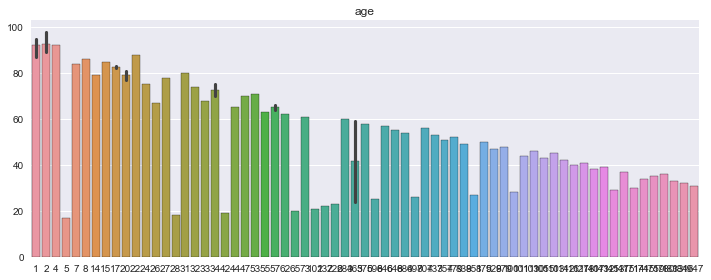

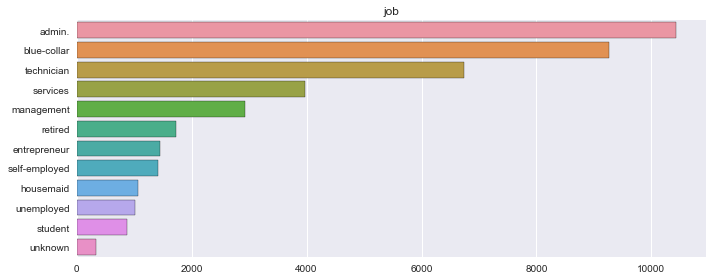

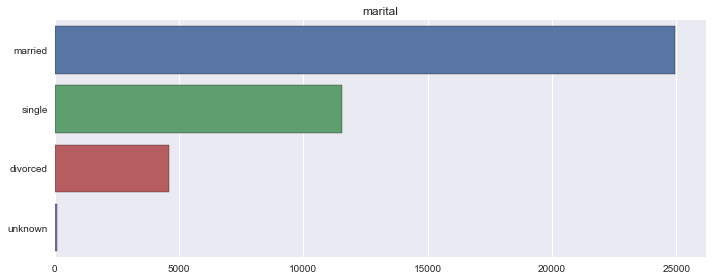

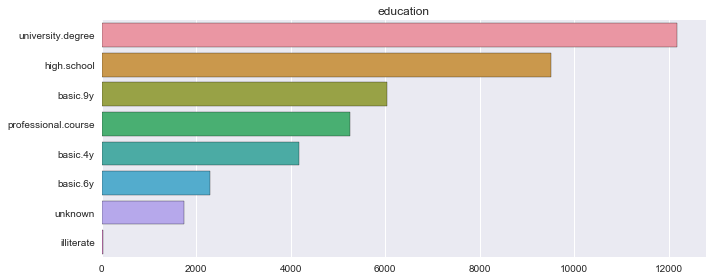

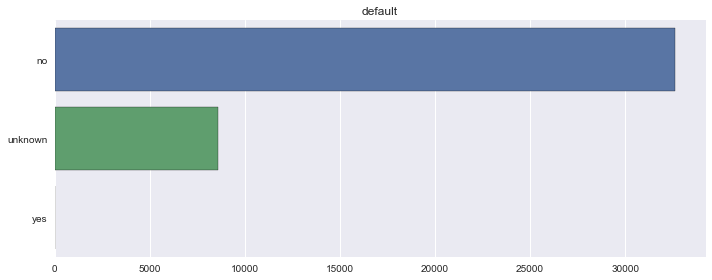

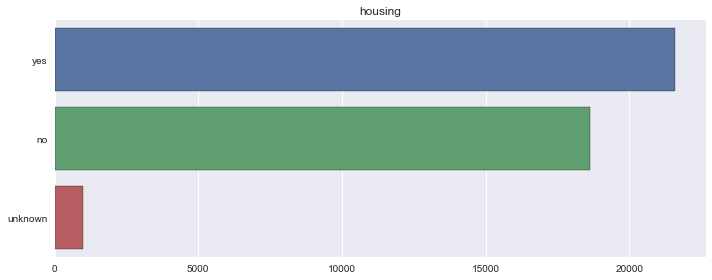

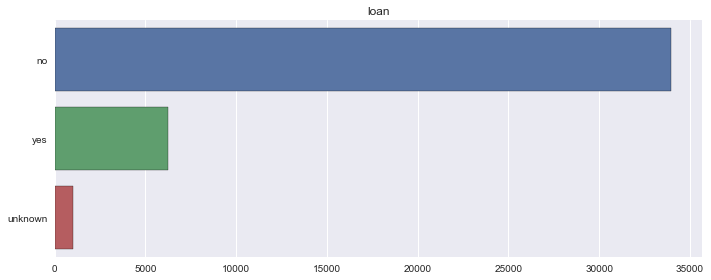

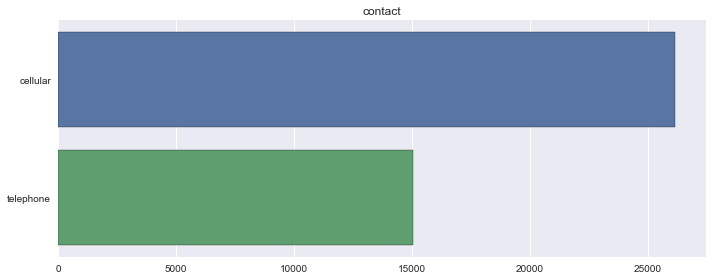

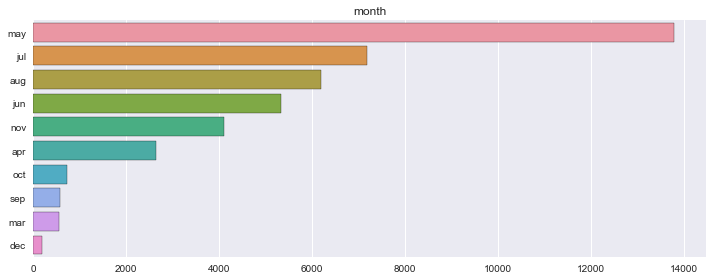

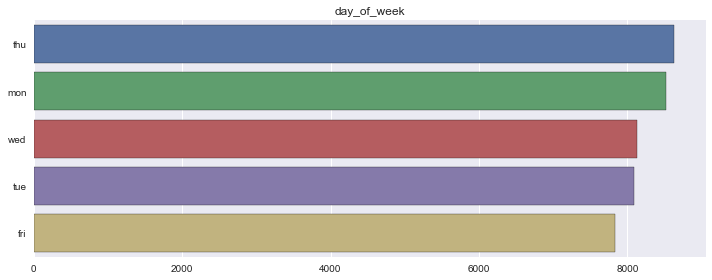

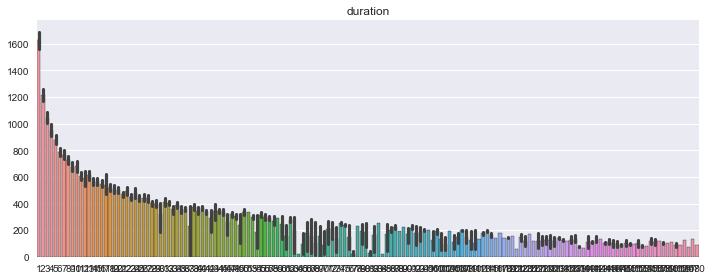

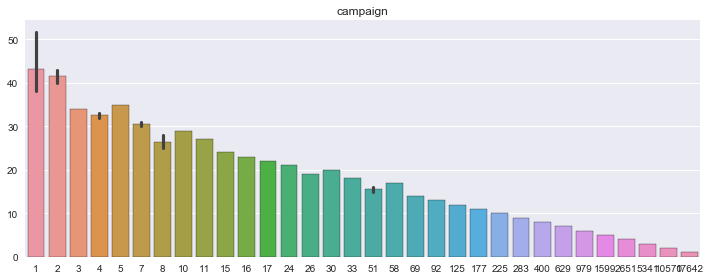

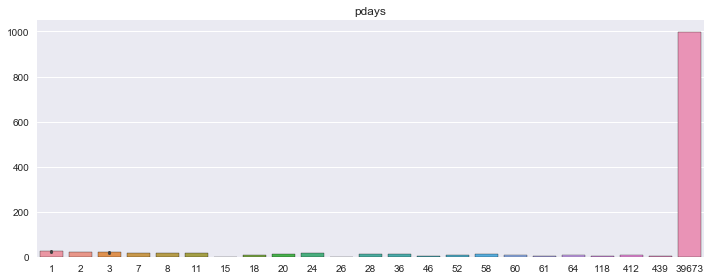

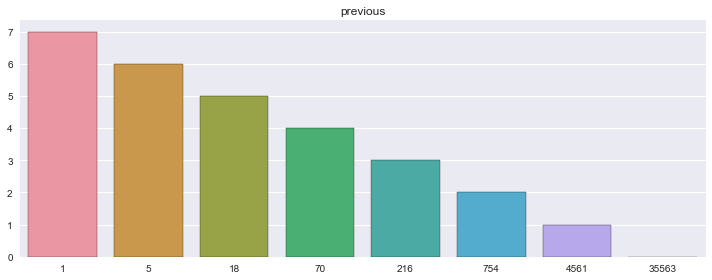

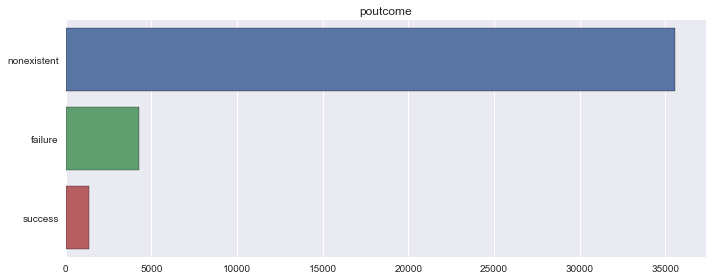

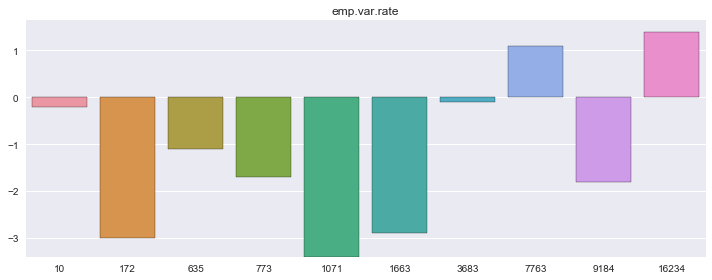

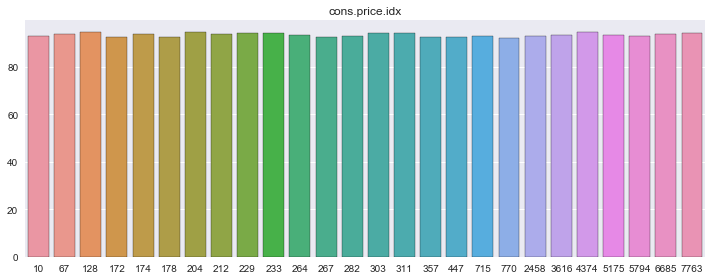

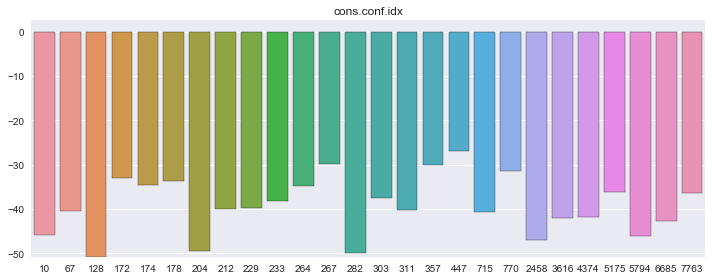

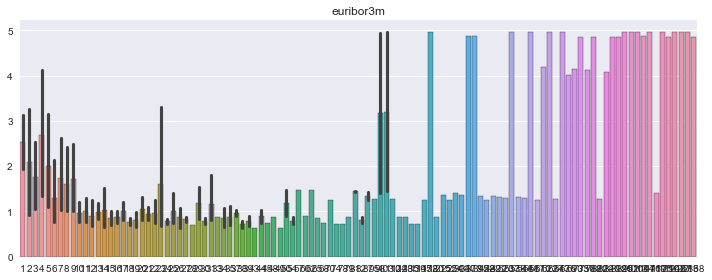

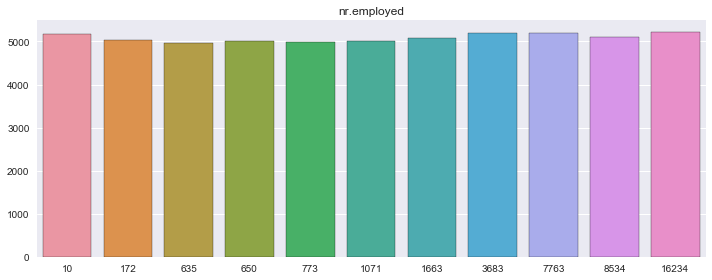

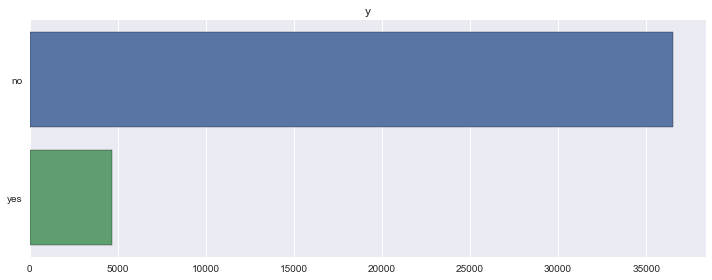

In [19]:
for col in df.columns:
    plt.figure(figsize=(10,4))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

Imbalanced Data:
**Default, Loan:** has 80% data as 'No' and 20% as 'Yes', this is significant imbalance.

Unknown Data:
**Job, Education, Contact, Poutcome** have some data which is 'unknown'.


In [25]:
df[((df.pdays==999)) & (df.y=='yes')].shape

(3673, 21)

#### Performing Chi-Square Test

In [4]:
#Function converting column values into numerical vectors
def column_vectorizer(df, column_name):
    return df[column_name].apply(lambda x: column_dict(df, column_name)[x])

def column_dict(df, column_name):
    column_vector = {}
    for i, item in enumerate(df[column_name].unique()):
        column_vector[item] = i
    return column_vector

for col in df.columns:
    df[col+'_vec'] = column_vectorizer(df, col)
    
#Performing Chi-Square Test
chisquare_test = stats.chisquare(np.array(df.iloc[:,21:]))
chi_sq = []
for i in chisquare_test[1]:
    chi_sq.append("%.10f" %i)

print(df.iloc[:,21:].columns)
print(chi_sq)

#plt.figure(figsize=(11,4))
#sns.barplot(chi_sq, [i for i in range(21)])
#plt.tight_layout()

Index(['age_vec', 'job_vec', 'marital_vec', 'education_vec', 'default_vec',
       'housing_vec', 'loan_vec', 'contact_vec', 'month_vec',
       'day_of_week_vec', 'duration_vec', 'campaign_vec', 'pdays_vec',
       'previous_vec', 'poutcome_vec', 'emp.var.rate_vec',
       'cons.price.idx_vec', 'cons.conf.idx_vec', 'euribor3m_vec',
       'nr.employed_vec', 'y_vec'],
      dtype='object')
['0.0000000000', '0.0000000000', '1.0000000000', '0.0000000000', '1.0000000000', '1.0000000000', '0.0000000034', '1.0000000000', '0.0000000000', '0.1768195686', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '1.0000000000']


Result: We see that the p-value is greater than 0.01 on Marital, Education, Default, Housing, Loan, Contact, this suggests that these features are dependent on Target and we simply cannot ignore them. 

So we will perform Imputation in below format:
1. Add 50% of 'Yes' data from Loan and Duration to 'No'. Because we think 'No' is added because the information was not collected.
2. Consider 'Unkowns' in Education, Job columns as a new feature.
3. Keep Housing, Marital and Contact as it is.

## Performing Imputation

##### 0. Spearman

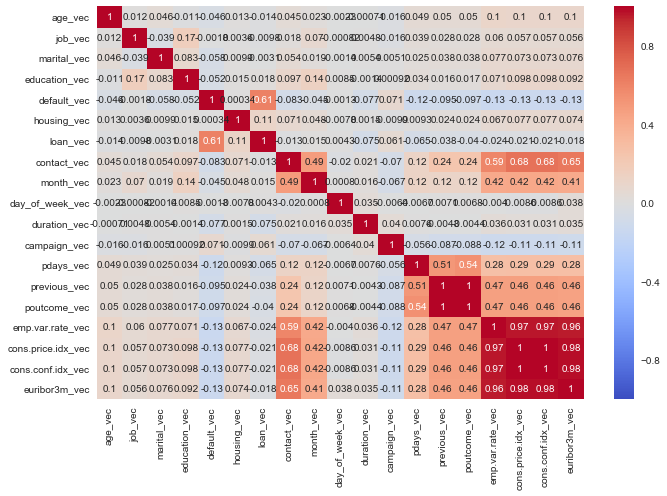

In [10]:
plt.figure(figsize=(10,7))
sns.heatmap(df.iloc[:,20:40].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.tight_layout()

Result:
1. Loan and Default are most negatively correlated to Duration. So we will use Balance for our comparison.
2. Poutcome has most negative correlation with Contact.
3. Pdays has most negative correlation with Contact.

##### 1. Loan Column

In [5]:
df[(df.loan_vec==0) & (df.duration<150)].shape

(13838, 42)

(41188, 42)


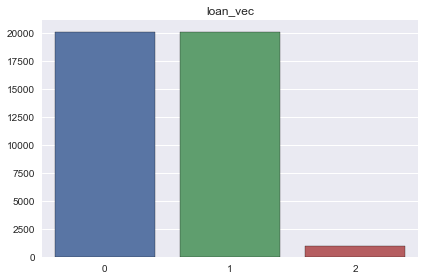

In [12]:
#We have seen 358 of 691 are likely to take a Loan when duration<150,
#so we will replace those with Loan='No' keeping 150 thrshold

df[(df.loan_vec==1) & (df.duration<150)].shape
condition = (df.loan_vec==0) & (df.duration<150)
balance_df = df[condition]
balance_df.loan_vec.replace(0,1, inplace=True)
df = pd.concat([balance_df, df[~condition]])
print(df.shape)
col='loan_vec'
sns.barplot(df[col].value_counts().index, df[col].value_counts().values)
plt.title(col)
plt.tight_layout()
plt.show()

##### 2. Default Column

(41188, 42)


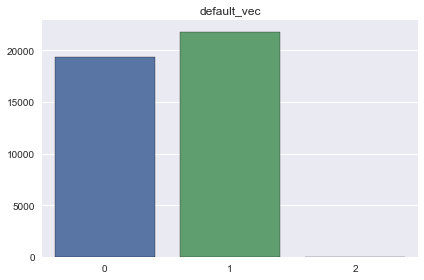

In [7]:
#We have seen that 66 of 76 people default when Duration<150, while 72 of 76 default when Duration<400
#So we will again take 150 as the threshold limit
condition = (df.default_vec==0) & (df.duration<150)
balance_df = df[condition]
balance_df.default_vec.replace(0,1, inplace=True)
df = pd.concat([balance_df, df[~condition]])
print(df.shape)
col='default_vec'
sns.barplot(df[col].value_counts().index, df[col].value_counts().values)
plt.title(col)
plt.tight_layout()
plt.show()

##### 3. Poutcome Column

In [8]:
#We see that where ever poutcome='success', the contact='cellphone'. However, same thing is for 'failure'.
df[df.poutcome=='success'].contact.value_counts()

cellular     1270
telephone     103
Name: contact, dtype: int64

##### 4. Pdays Column

(41188, 42)


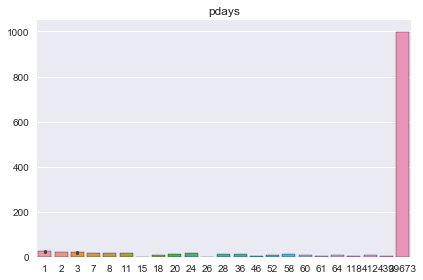

In [9]:
#Eventhough we see correlation with Contact, we will replace the NaN in pdays with mean of values in pdays.
condition = (df.pdays==-1)
balance_df = df[condition]
pdays_mean = np.floor(np.mean(df[~condition].pdays))
balance_df.pdays.replace(999,pdays_mean, inplace=True)
df = pd.concat([balance_df, df[~condition]])
print(df.shape)
col='pdays'
sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
plt.title(col)
plt.tight_layout()
plt.show()

## Peforming data modeling

In [7]:
bank_df = df.copy()
#features = ['job_vec','marital_vec','education_vec','default_vec','loan_vec','campaign_vec',
#            'nr.employed','euribor3m','emp.var.rate','cons.price.idx','cons.conf.idx','day_of_week_vec','y_vec']

features = ['job_vec','marital_vec','education_vec','default_vec','loan_vec','duration_vec','campaign_vec',
            'nr.employed','euribor3m','emp.var.rate','cons.price.idx','cons.conf.idx','day_of_week_vec','y_vec']

X = bank_df[features].iloc[:,:-1]
y = bank_df[features].iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

bank_df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign_vec,pdays_vec,previous_vec,poutcome_vec,emp.var.rate_vec,cons.price.idx_vec,cons.conf.idx_vec,euribor3m_vec,nr.employed_vec,y_vec
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,0,0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,0,0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,0,0,0,0,0,0,0,0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,0,0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,0,0,0,0,0,0,0,0,0


#### Implementing Decision Tree Classifier

In [159]:
import time
start = time.time()
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve, auc
#dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=20000, min_samples_leaf=1500)
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=5, min_samples_leaf=10)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
scores_dt = dt.predict_proba(X_test)
y_scores_dt = []
for i in range(len(scores_dt)):
    y_scores_dt.append(scores_dt[i][1])

fpr_dt, tpr_dt, threshold_dt = roc_curve(y_test, y_scores_dt, pos_label=1)
print("Decision Tree Accuracy: %5f" %accuracy_score(y_test, y_pred_dt))
print("Decision Tree AUC: %5f" %auc(fpr_dt, tpr_dt))
print("Time taken: {}".format(time.time()-start))

Decision Tree Accuracy: 0.885328
Decision Tree AUC: 0.841789
Time taken: 0.17245817184448242


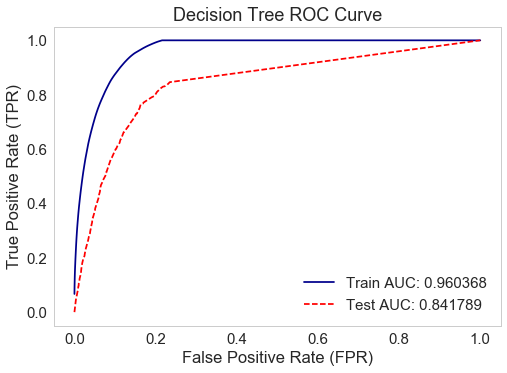

In [160]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})
scores_train = dt.predict_proba(X_train)
y_scores_train = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)

plt.plot(fpr_dt_train, tpr_dt_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_dt, tpr_dt, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_dt, tpr_dt))
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

#### Implementing Logistic Regression

In [161]:
start=time.time()
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
#lr = LogisticRegression(penalty='l1', C=0.01)
lr = lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
scores_lr = lr.predict_proba(X_test)
y_scores_lr = []
for i in range(len(scores_lr)):
    y_scores_lr.append(scores_lr[i][1])
    
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, y_scores_lr, pos_label=1)
print("Logistic Regression Accuracy: %5f" %accuracy_score(y_test, y_pred_lr))
print("Logistic Regression AUC: %5f" %auc(fpr_lr, tpr_lr))
print("Time taken: {}".format(time.time()-start))

Logistic Regression Accuracy: 0.891074
Logistic Regression AUC: 0.863352
Time taken: 0.21306824684143066


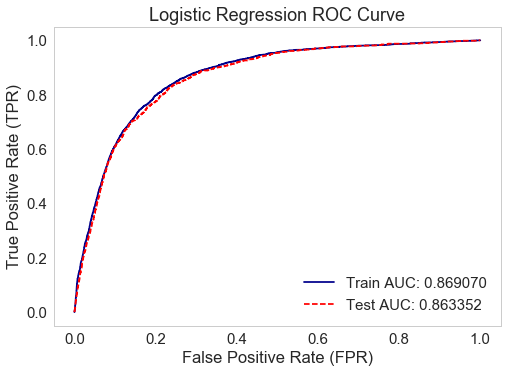

In [30]:
sns.set_style("whitegrid", {'axes.grid' : False})
scores_train = lr.predict_proba(X_train)
y_scores_train = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])
    
fpr_lr_train, tpr_lr_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)

plt.plot(fpr_lr_train, tpr_lr_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_lr_train, tpr_lr_train))
plt.plot(fpr_lr, tpr_lr, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_lr, tpr_lr))
plt.title("Logistic Regression ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

#### Implementing SVM

In [163]:
start=time.time()
from sklearn.svm import SVC
svm = SVC(probability=True)
#svm = SVC(kernel='linear', probability=True, C=0.001)
svm = svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
scores_svm = svm.predict_proba(X_test)
y_scores_svm = []
for i in range(len(scores_svm)):
    y_scores_svm.append(scores_svm[i][1])
    
fpr_svm, tpr_svm, threshold_svm = roc_curve(y_test, y_scores_svm, pos_label=1)
print("SVM Accuracy: %5f" % accuracy_score(y_test, y_pred_svm))
print("SVM AUC: %5f" %auc(fpr_svm, tpr_svm))
print("Time taken: {}".format(time.time()-start))

SVM Accuracy: 0.888322
SVM AUC: 0.824404
Time taken: 1056.2081339359283


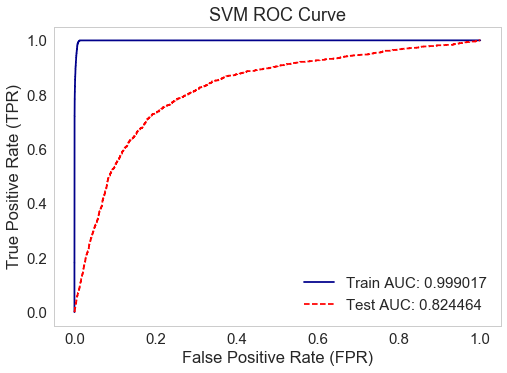

In [157]:
sns.set_style("whitegrid", {'axes.grid' : False})
scores_train = svm.predict_proba(X_train)
y_scores_train = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])
fpr_svm_train, tpr_svm_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)

plt.plot(fpr_svm_train, tpr_svm_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_svm_train, tpr_svm_train))
plt.plot(fpr_svm, tpr_svm, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_svm, tpr_svm))
plt.title("SVM ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

#### Implementing Random Forest

In [162]:
start = time.time()
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='entropy', n_estimators=100, min_samples_leaf=5, min_samples_split=3000)
#rf = RandomForestClassifier(criterion='entropy', n_estimators=10, min_samples_leaf=50)
rf = rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
scores_rf = rf.predict_proba(X_test)
y_scores_rf = []
for i in range(len(scores_rf)):
    y_scores_rf.append(scores_rf[i][1])
    
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, y_scores_rf, pos_label=1)
print("Random Forest Accuracy: %5f" %accuracy_score(y_test, y_pred_rf))
print("Random Forest AUC: %5f" %auc(fpr_rf,tpr_rf))
print("Time taken: {}".format(time.time()-start))

Random Forest Accuracy: 0.888403
Random Forest AUC: 0.877391
Time taken: 1.7206275463104248


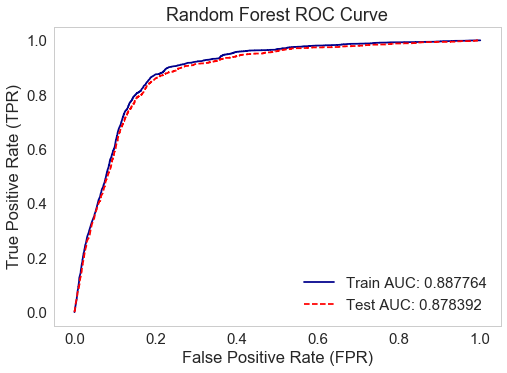

In [155]:
sns.set_style("whitegrid", {'axes.grid' : False})
scores_train = rf.predict_proba(X_train)
y_scores_train = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf, tpr_rf, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf, tpr_rf))
plt.title("Random Forest ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

#### Tuning each model

In [167]:
#Decision Trees
start=time.time()
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=5, min_samples_leaf=10)
dt = dt.fit(X_train, y_train)
scores_dt = dt.predict_proba(X_test)
y_scores_dt = []
for i in range(len(scores_dt)):
    y_scores_dt.append(scores_dt[i][1])
fpr_dt, tpr_dt, threshold_dt = roc_curve(y_test, y_scores_dt, pos_label=1)
print("Decision Tree Time: {}".format(time.time()-start))

#Logistic Regression
start=time.time()
lr = LogisticRegression(penalty='l1', C=0.01)
lr = lr.fit(X_train, y_train)
scores_lr = lr.predict_proba(X_test)
y_scores_lr = []
for i in range(len(scores_lr)):
    y_scores_lr.append(scores_lr[i][1])
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, y_scores_lr, pos_label=1)
print("Logistic Regression Time: {}".format(time.time()-start))

#SVM
start=time.time()
svm = SVC(probability=True, kernel='linear', C=0.001)
svm = svm.fit(X_train, y_train)
scores_train = svm.predict_proba(X_train)
y_scores_train = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])
fpr_svm_train, tpr_svm_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
print("SVM Time: {}".format(time.time()-start))

#Random Forest
start=time.time()
rf = RandomForestClassifier(criterion='entropy', n_estimators=5, min_samples_split=5, min_samples_leaf=20)
rf = rf.fit(X_train, y_train)
scores_train = rf.predict_proba(X_train)
y_scores_train = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
print("Random Forest Time: {}".format(time.time()-start))

Decision Tree Time: 0.15795350074768066
Logistic Regression Time: 4.862325191497803
SVM Time: 134.6349184513092
Random Forest Time: 0.1684398651123047


## Comparing Model Results

#### Plotting the ROC Curve: Training Data

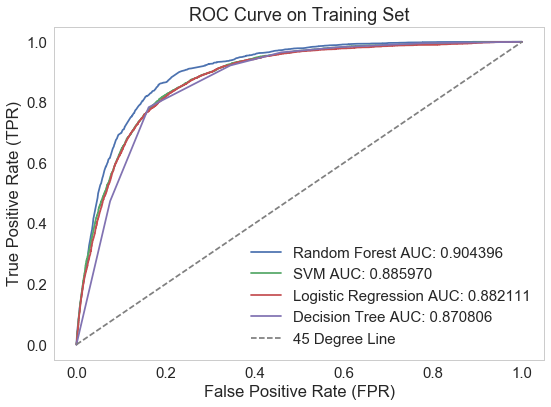

In [55]:
plt.figure(figsize=(8,6))
plt.plot(fpr_rf_train, tpr_rf_train, label='Random Forest AUC: %3f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_svm_train, tpr_svm_train, label='SVM AUC: %3f' %auc(fpr_svm_train, tpr_svm_train))
plt.plot(fpr_lr_train, tpr_lr_train, label='Logistic Regression AUC: %3f' %auc(fpr_lr_train, tpr_lr_train))
plt.plot(fpr_dt_train, tpr_dt_train, label='Decision Tree AUC: %3f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot([0,1], [0,1], color='grey', ls = '--', label='45 Degree Line')
plt.title("ROC Curve on Training Set")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Result: Clearly, after tuning Random Forest performs better than other models and has AUC of 0.904 on the Training set.

#### Plotting the ROC Curve: Test Data

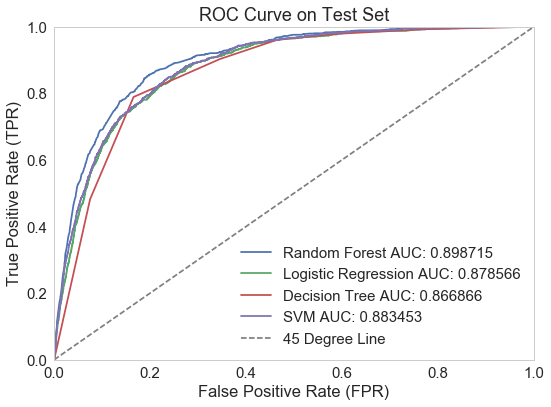

In [56]:
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label="Random Forest AUC: %3f" %auc(fpr_rf,tpr_rf))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression AUC: %3f" %auc(fpr_lr,tpr_lr))
plt.plot(fpr_dt, tpr_dt, label="Decision Tree AUC: %3f" %auc(fpr_dt,tpr_dt))
plt.plot(fpr_svm, tpr_svm, label="SVM AUC: %3f" %auc(fpr_svm,tpr_svm))
plt.plot([0,1], [0,1], color='grey', ls = '--', label='45 Degree Line')
#plt.plot(threshold_dt, color='red', ls='--', label='Threshold Line')
plt.title("ROC Curve on Test Set")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Result: Random Forest has highest AUC of 0.89 and Accuracy of 0.90 on the Training set. Hence we will use this as predictor to calculate feature importances.

In [75]:
from sklearn.metrics import classification_report
print("Training:", classification_report(y_train, rf.predict(X_train)))
print("Test:", classification_report(y_test, y_pred_rf))

Training:              precision    recall  f1-score   support

          0       0.90      0.99      0.94     25550
          1       0.66      0.13      0.22      3281

avg / total       0.87      0.89      0.86     28831

Test:              precision    recall  f1-score   support

          0       0.90      0.99      0.94     10998
          1       0.65      0.13      0.21      1359

avg / total       0.87      0.90      0.86     12357



#### Feature Importance Ranking: Most important predictors

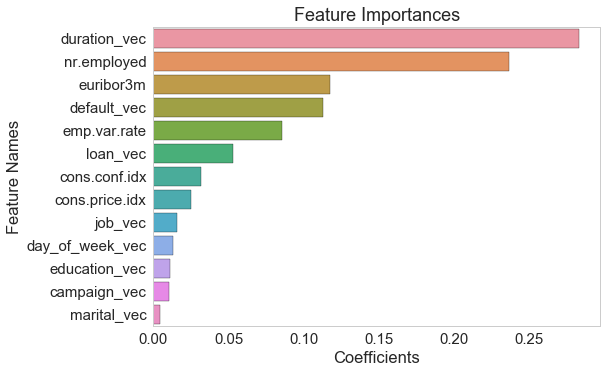

In [77]:
#Creating feature importance dictionary
feature_importance_dict = {}
for i in range(len(X.columns)):
    feature_importance_dict[X.columns[i]] = rf.feature_importances_[i]
#Sorting the dict in descending
feature_importance_dict = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
#Unpacking the tuple
feature_importance_keys,feature_importance_values = zip(*feature_importance_dict)
#Plotting the results
sns.barplot(np.array(feature_importance_values), np.array(feature_importance_keys))
plt.title('Feature Importances')
plt.xlabel('Coefficients')
plt.ylabel('Feature Names')

Results:

**Duration, Euribor and Nr.Employed** are three most importat predictors of subscription. So banks should focus on them.
- Duration: Indicator of long a customer is member. Banks should retain existing customer by providing good services as they are the one who will most likely keep subscribing.
- Euribor: Indicator Interest Rate. If Banks offer good interest on fixed term deposit client will subscribe.
- Nr.Employed: Indicates number of employees. If there are more employees in banks they can handle more customers